In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-12-24 11:20:40--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.009s  

2025-12-24 11:20:40 (96.2 MB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

In [312]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [162]:
df.head(5)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [313]:
cols = ['engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg']

In [344]:
df_use = df[cols]

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

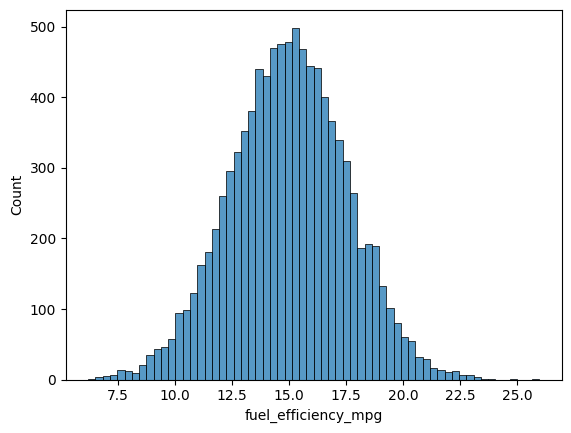

In [315]:
sns.histplot(df['fuel_efficiency_mpg']) # normal dist

In [316]:
df_use.isnull().sum() # Q1: 'horsepower'

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [227]:
df_use.horsepower.median() # Q1: 149

np.float64(149.0)

In [228]:
n = len(df_use)
n

9704

In [256]:
# Shuffle the dataset (the filtered one you created above), use seed 42.
idx = np.arange(n) # [0, 1, 2 ... 9704]
np.random.seed(42)
np.random.shuffle(idx) # shuffle the idx

In [257]:
idx

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

In [266]:
n_train = int(n * 0.6)
n_val = int(n * 0.2)

In [267]:
df_train = df_use.iloc[idx[:n_train]]
df_val = df_use.iloc[idx[n_train: n_train + n_val]]
df_test = df_use.iloc[idx[n_train + n_val:]]

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

In [268]:
len(df_val) + len(df_train) + len(df_test)

9704

In [269]:
df_train = df_train.drop('fuel_efficiency_mpg', axis=1)
df_val = df_val.drop('fuel_efficiency_mpg', axis=1)
df_test = df_test.drop('fuel_efficiency_mpg', axis=1)

In [270]:
horsepower_mean = int(df_train.horsepower.mean())
horsepower_mean

149

In [271]:
df_train = df_train.fillna(horsepower_mean)
df_val = df_val.fillna(horsepower_mean)
df_test = df_test.fillna(horsepower_mean)
df_train.isnull().sum()

engine_displacement    0
horsepower             0
vehicle_weight         0
model_year             0
dtype: int64

Train with 0 filling and mean seperately to see which one works better

In [317]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    
    w_full = XTX_inv.dot(X.T).dot(y)
    
    w0 = w_full[0]   
    w = w_full[1:]
    return w0, w

In [318]:
def rmse(y, y_pred):
    '''return root mean squared error'''
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [276]:
X_train = df_train.values
w0, w = train_linear_regression(X_train, y_train)
X_val = df_val.values
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.46)

In [275]:
# mean: 0.46
# 0: 0.52

In [290]:
def train_linear_regression_reg(X, y, r = 0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    
    w_full = XTX_inv.dot(X.T).dot(y)
    
    w0 = w_full[0]   
    w = w_full[1:]
    return w0, w

Try different numbers for regularization

In [281]:
X_train = df_train.values
r_vals = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_vals:
    w0, w = train_linear_regression(X_train, y_train, r)
    X_val = df_val.values
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred) # 0.01 is the best
    print(score)

0.4635124054372282
0.46328862002307203
0.4653977754097305
0.46948306181259897
0.47024401441079533
0.4703477843143524
0.4704428621906824


Impact of Seeding on the scores

In [325]:
def prepare_data(df_use = df_use, s = 0):
    idx = np.arange(n) # [0, 1, 2 ... 9704]
    np.random.seed(s)
    np.random.shuffle(idx) # shuffle the idx
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    
    df_train = df_use.iloc[idx[:n_train]]
    df_val = df_use.iloc[idx[n_train: n_train + n_val]]
    df_test = df_use.iloc[idx[n_train + n_val:]]
    
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values
    
    df_train = df_train.drop('fuel_efficiency_mpg', axis=1)
    df_val = df_val.drop('fuel_efficiency_mpg', axis=1)
    df_test = df_test.drop('fuel_efficiency_mpg', axis=1)
    
    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)
    df_test = df_test.fillna(0)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [326]:
def train_with_diff_s():
    df_train, df_val, df_test, y_train, y_val, y_test = prepare_data(df_use, s)
    X_train = df_train.values
    w0, w = train_linear_regression(X_train, y_train)
    X_val = df_val.values
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    print(f"Seed: {s}, Score: {score}")
    return score

In [327]:
s_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

for s in s_vals:
    scores.append(train_with_diff_s())

std = np.std(scores)
print(round(std, 3))

Seed: 0, Score: 0.5210993169598925
Seed: 1, Score: 0.5218422383688939
Seed: 2, Score: 0.5230384520166863
Seed: 3, Score: 0.516121533459799
Seed: 4, Score: 0.511186953028298
Seed: 5, Score: 0.5286833855550958
Seed: 6, Score: 0.5322418918560308
Seed: 7, Score: 0.5095258233918671
Seed: 8, Score: 0.5149083792586704
Seed: 9, Score: 0.5131330922540438
0.007


### Question 6


    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?


In [348]:
def prepare_data(df_use = df_use, s = 9):
    idx = np.arange(n) 
    np.random.seed(s)
    np.random.shuffle(idx)
    n_train = int(n * 0.6)
    n_val = int(n * 0.2)
    
    df_train = df_use.iloc[idx[:n_train]]
    df_val = df_use.iloc[idx[n_train: n_train + n_val]]
    df_test = df_use.iloc[idx[n_train + n_val:]]
    
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values
    
    df_train = df_train.drop('fuel_efficiency_mpg', axis=1)
    df_val = df_val.drop('fuel_efficiency_mpg', axis=1)
    df_test = df_test.drop('fuel_efficiency_mpg', axis=1)
    
    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)
    df_test = df_test.fillna(0)

    df_full_train = pd.concat([df_train, df_val])
    df_full_train =  df_full_train.reset_index(drop=True)
    y_full_train = np.concatenate([y_train, y_val])
    
    return df_full_train, df_test, y_full_train, y_test

In [349]:
df_full_train, df_test, y_full_train, y_test = prepare_data(df_use)
X_train = df_full_train.values
w0, w = train_linear_regression_reg(X_train, y_full_train)
X_test = df_test.values
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
print(score)

0.5155043369311519
